# Week 5 Kaggle Mini-Project

## Introduction

In this project, we will design and apply a Generative Adversarial Network to translate an image dataset into Monet-style paintings. The dataset is provided by the Kaggle Getting Started Competition for GANs(https://www.kaggle.com/competitions/gan-getting-started/overview). The dataset consists of an image set of 7,038 photographs and another image set of 300 Monet paintings. All images are in size 256x256 pixels and in .jpeg and .tfrec formats.

Generative Adversarial Networks(GANs) are generative models that use deep learning techniques such as convolutional neural networks. They generally run unsupervised and consist of two neural networks that work against each other to become more accurate in their predictions. These two neural networks are referred to as the generator and the discriminator. The generator generates artificial data from the training data and the discriminator tries to classify the data as real or artificially created by the generator.

The main reference for this report is the Kaggle's recommended tutorial by Amy Jang(https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook).

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import random

from kaggle_datasets import KaggleDatasets

AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
GCS_PATH = KaggleDatasets().get_gcs_path()

In [3]:
MONET_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/monet_tfrec/*.tfrec'))
print('Monet TFRecord Files:', len(MONET_FILENAMES))

PHOTO_FILENAMES = tf.io.gfile.glob(str(GCS_PATH + '/photo_tfrec/*.tfrec'))
print('Photo TFRecord Files:', len(PHOTO_FILENAMES))

Monet TFRecord Files: 5
Photo TFRecord Files: 20


In [4]:
#https://stackoverflow.com/questions/40472139/obtaining-total-number-of-records-from-tfrecords-file-in-tensorflow
num_monet_samples = sum(1 for _ in tf.data.TFRecordDataset(MONET_FILENAMES))
print(f'The number of Monet image files: {num_monet_samples}')

num_photo_samples = sum(1 for _ in tf.data.TFRecordDataset(PHOTO_FILENAMES))
print(f'The number of Photo image files: {num_photo_samples}')

The number of Monet image files: 300
The number of Photo image files: 7038


In [5]:
IMAGE_SIZE = [256, 256]

def decode_image(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = (tf.cast(image, tf.float32) / 127.5) - 1
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

def read_tfrecord(example):
    tfrecord_format = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_image(example['image'])
    return image

In [6]:
def load_dataset(filenames, labeled=True, ordered=False):
    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

In [7]:
monet_ds = load_dataset(MONET_FILENAMES, labeled=True).batch(10)
photo_ds = load_dataset(PHOTO_FILENAMES, labeled=True).batch(10)

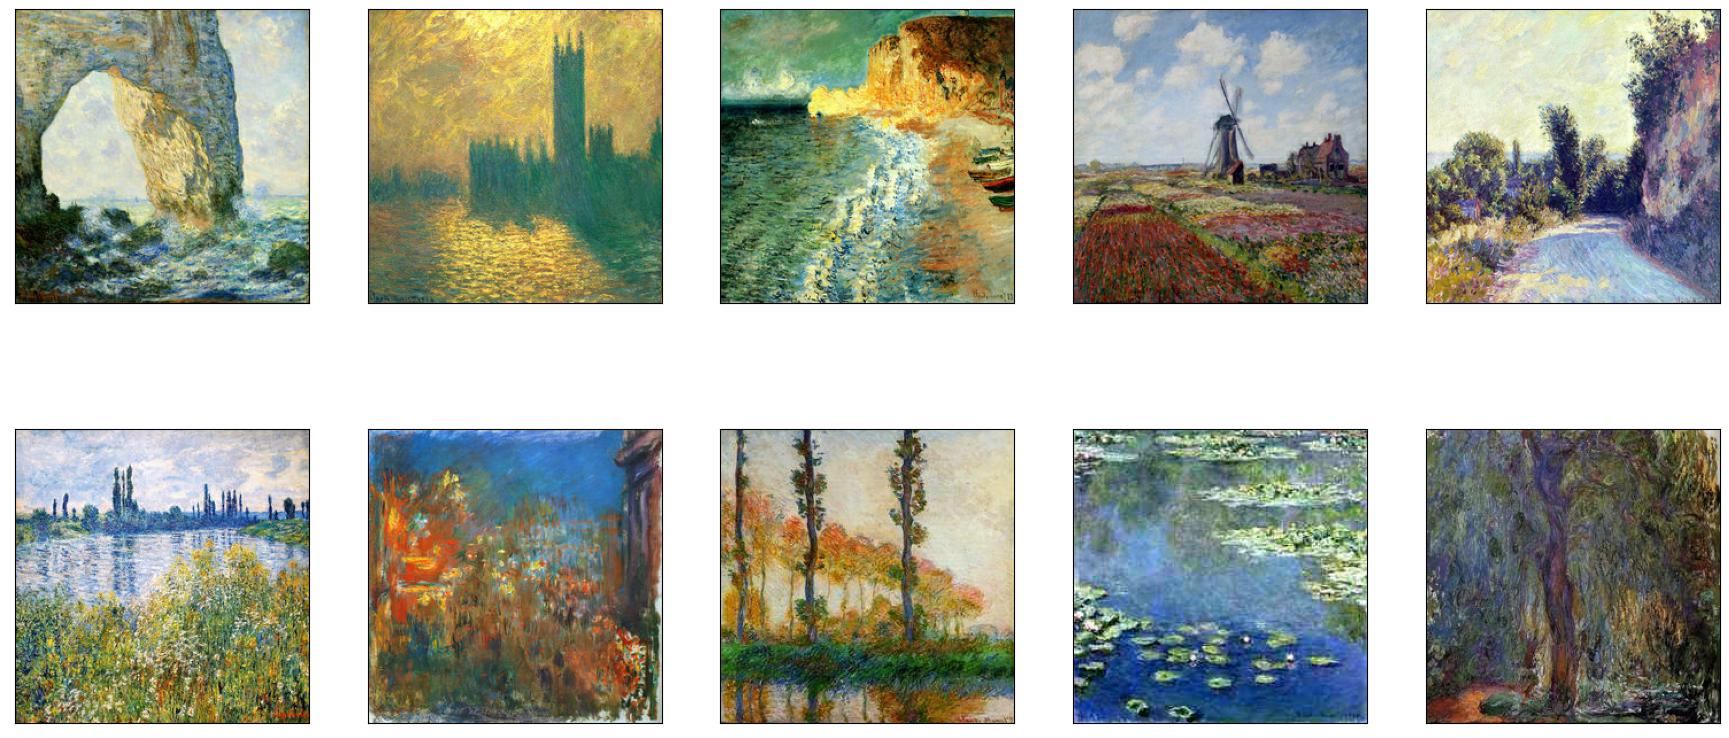

In [8]:
#Reference #2
monet_image = next(iter(monet_ds)) 
monet_image = monet_image.numpy()

fig = plt.figure(figsize=(22, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    ax.imshow(monet_image[i] / 2 + .5)

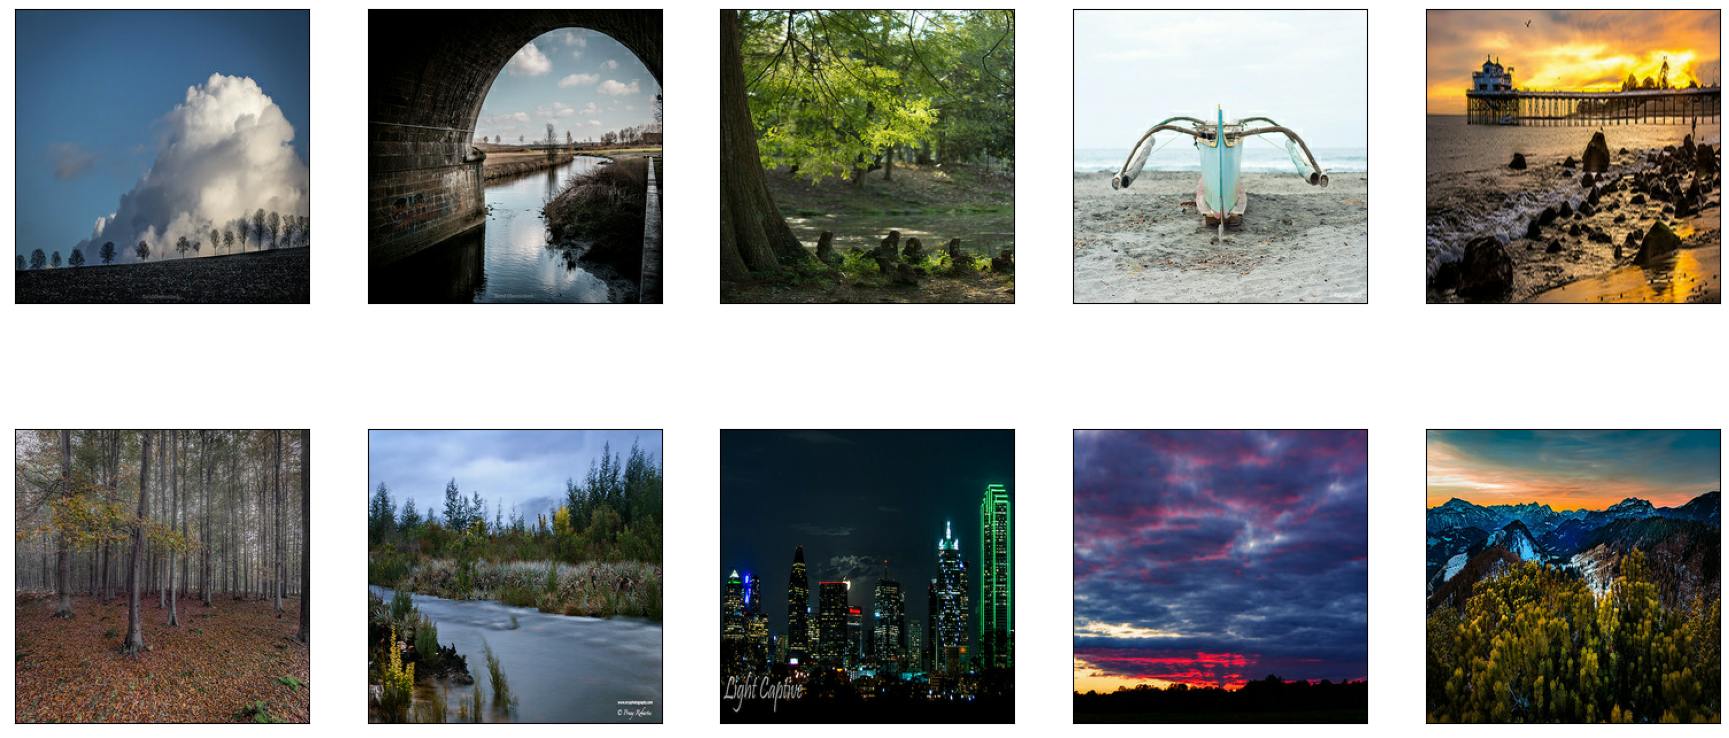

In [9]:
photo_image = next(iter(photo_ds)) 
photo_image = photo_image.numpy()

fig = plt.figure(figsize=(22, 10))
for i in range(10):
    ax = fig.add_subplot(2, 5, i+1, xticks=[], yticks=[])
    ax.imshow(photo_image[i] / 2 + .5)

The first set of images show Monet paintings and the second set of images show the photographs.

## Model Architecture

For this project, we need to build a GAN. The base model is from Amy Jang's CycleGAN tutorial and we will be modifying it in this project. CycleGANS can be used for unpaired image to image translation. There are 2 generators and 2 discriminators being trained in a CycleGAN. The discriminator is made up of strided convolution layers, batch norm layers, and LeakyReLU activations. The generator consists of a downsampler(encoder) and upsampler(decoder). The downsampler architecture is conv2D -> Instance Normalization -> Leaky ReLU. The upsampler architecture is conv2DTranspose -> Instance Normalization -> ReLU.

In [10]:
OUTPUT_CHANNELS = 3

def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.ReLU())

    return result

def upsample(filters, size):
    initializer = tf.random_normal_initializer(0., 0.02)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    

    result.add(tfa.layers.InstanceNormalization(gamma_initializer=gamma_init))

    result.add(layers.ReLU())

    return result

The generator consists of 5 downsampler blocks and 4 upsampler blocks. There are skip connections between the downsampler and upsampler. This is to help bypass the vanishing gradient problem by concatenating the output of a layer to multiple layers instead of only one.

In [11]:
def Generator():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample(64, 4, apply_instancenorm=False), 
        downsample(128, 4),
        downsample(256, 4),
        downsample(512, 4),
        downsample(512, 4),
    ]

    up_stack = [
        upsample(512, 4),
        upsample(256, 4), 
        upsample(128, 4), 
        upsample(64, 4) 
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

The discriminator consists of 3 downsamplers and an Conv2D layer output. It classifies the smaller 2D image as either real or fake(generated) depending on the number of pixel values. Higher pixel values means the image is real while a lower value means the image is fake.

In [12]:
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample(64, 4, True)(x) 
    down2 = downsample(128, 4)(down1) 
    down3 = downsample(256, 4)(down2) 

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer, activation = 'relu')(down3) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [13]:
monet_generator = Generator() # transforms photos to Monet-esque paintings
photo_generator = Generator() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator() # differentiates real photos and generated photos

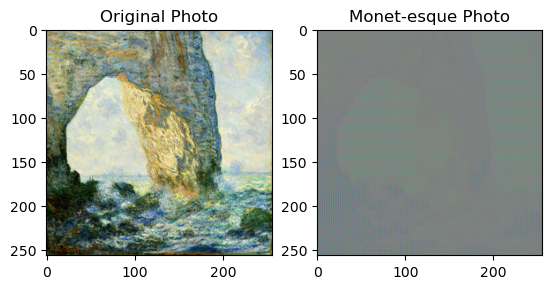

In [14]:
to_monet = monet_generator(monet_image)

plt.subplot(1, 2, 1)
plt.title("Original Photo")
plt.imshow(monet_image[0] * 0.5 + 0.5)

plt.subplot(1, 2, 2)
plt.title("Monet-esque Photo")
plt.imshow(to_monet[0] * 0.5 + 0.5)
plt.show()

The CycleGAN function is taken from the tutorial.

In [15]:
class CycleGan(keras.Model):
    def __init__(
        self,
        monet_generator,
        photo_generator,
        monet_discriminator,
        photo_discriminator,
        lambda_cycle=10,
    ):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle
        
    def compile(
        self,
        m_gen_optimizer,
        p_gen_optimizer,
        m_disc_optimizer,
        p_disc_optimizer,
        gen_loss_fn,
        disc_loss_fn,
        cycle_loss_fn,
        identity_loss_fn
    ):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn
        
    def train_step(self, batch_data):
        real_monet, real_photo = batch_data
        
        with tf.GradientTape(persistent=True) as tape:
            # photo to monet back to photo
            fake_monet = self.m_gen(real_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # monet to photo back to monet
            fake_photo = self.p_gen(real_monet, training=True)
            cycled_monet = self.m_gen(fake_photo, training=True)

            # generating itself
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # discriminator used to check, inputing real images
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_real_photo = self.p_disc(real_photo, training=True)

            # discriminator used to check, inputing fake images
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)

            # evaluates generator loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # evaluates total cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # evaluates total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # evaluates discriminator loss
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

        # Calculate the gradients for generator and discriminator
        monet_generator_gradients = tape.gradient(total_monet_gen_loss,
                                                  self.m_gen.trainable_variables)
        photo_generator_gradients = tape.gradient(total_photo_gen_loss,
                                                  self.p_gen.trainable_variables)

        monet_discriminator_gradients = tape.gradient(monet_disc_loss,
                                                      self.m_disc.trainable_variables)
        photo_discriminator_gradients = tape.gradient(photo_disc_loss,
                                                      self.p_disc.trainable_variables)

        # Apply the gradients to the optimizer
        self.m_gen_optimizer.apply_gradients(zip(monet_generator_gradients,
                                                 self.m_gen.trainable_variables))

        self.p_gen_optimizer.apply_gradients(zip(photo_generator_gradients,
                                                 self.p_gen.trainable_variables))

        self.m_disc_optimizer.apply_gradients(zip(monet_discriminator_gradients,
                                                  self.m_disc.trainable_variables))

        self.p_disc_optimizer.apply_gradients(zip(photo_discriminator_gradients,
                                                  self.p_disc.trainable_variables))
        
        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

Now, we have to define loss functions and optimizers for both models. This is also taken from the tutorial

In [16]:
#Define Generator Loss
def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(generated), generated)

In [17]:
#Define Discriminator Loss
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.ones_like(real), real)

    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True, reduction=tf.keras.losses.Reduction.NONE)(tf.zeros_like(generated), generated)

    total_disc_loss = real_loss + generated_loss

    return total_disc_loss * 0.5

In [18]:
def calc_cycle_loss(real_image, cycled_image, LAMBDA):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

    return LAMBDA * loss1

In [19]:
def identity_loss(real_image, same_image, LAMBDA):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return LAMBDA * 0.5 * loss

In [20]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-5, beta_1=0.5)

In [21]:
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [22]:
monet_dataset = load_dataset(MONET_FILENAMES, labeled=True).batch(1)
photo_dataset = load_dataset(PHOTO_FILENAMES, labeled=True).batch(1)

In [23]:
cycle_gan_model.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=50
)

Epoch 1/50
300/300 [==============================] - 83s 141ms/step - monet_gen_loss: 10.3408 - photo_gen_loss: 10.9086 - monet_disc_loss: 0.6375 - photo_disc_loss: 0.6205
Epoch 2/50
300/300 [==============================] - 45s 139ms/step - monet_gen_loss: 6.2744 - photo_gen_loss: 6.5636 - monet_disc_loss: 0.5999 - photo_disc_loss: 0.5815
Epoch 3/50
300/300 [==============================] - 45s 139ms/step - monet_gen_loss: 4.8577 - photo_gen_loss: 5.0091 - monet_disc_loss: 0.6082 - photo_disc_loss: 0.5834
Epoch 4/50
300/300 [==============================] - 45s 139ms/step - monet_gen_loss: 4.4753 - photo_gen_loss: 4.5848 - monet_disc_loss: 0.5946 - photo_disc_loss: 0.5858
Epoch 5/50
300/300 [==============================] - 45s 137ms/step - monet_gen_loss: 4.2330 - photo_gen_loss: 4.3100 - monet_disc_loss: 0.5382 - photo_disc_loss: 0.5626
Epoch 6/50
300/300 [==============================] - 45s 139ms/step - monet_gen_loss: 4.0432 - photo_gen_loss: 4.1115 - monet_disc_loss: 0.512

### Results and Analysis

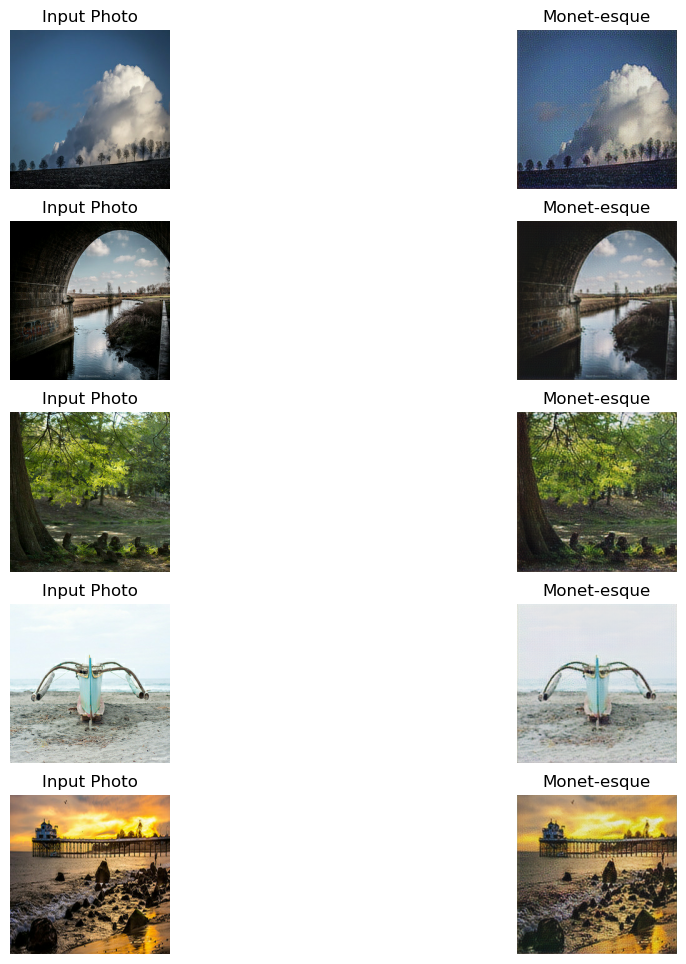

In [24]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Model Commentary

The generated images don't look too different from the input images. There's a subtle difference in the first and last generated image from the real image. Even with 50 epochs, the model doesn't translate the input image into monet-esque image that well. We will tune the hyperparameters and modify the generator and discriminator slightly.

## Alternate model and Hyperparameter Tuning

For hyperparameter tuning, I will increase the initializer standard deviation to 0.05 to see how it affects the model. Furthermore, I will try various learning_rate parameters between (1e-4, 2e-5). I've also changed the model architecture slightly by using BatchNormalization instead of InstanceNormalization as well as adding a few more downsampling blocks and upsampling blocks to the generator.

In [28]:
def downsample1(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.05)

    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if apply_instancenorm:
        result.add(tf.keras.layers.BatchNormalization())

    result.add(layers.ReLU())

    return result

def upsample1(filters, size):
    initializer = tf.random_normal_initializer(0., 0.05)

    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    

    result.add(tf.keras.layers.BatchNormalization())

    result.add(layers.ReLU())

    return result

In [29]:
def Generator1():
    inputs = layers.Input(shape=[256,256,3])

    down_stack = [
        downsample1(64, 4, apply_instancenorm=False), 
        downsample1(128, 4),
        downsample1(256, 4),
        downsample1(512, 4),
        downsample1(512, 4),
        downsample1(512, 4),
        downsample1(512, 4)
    ]

    up_stack = [
        upsample1(512, 4),
        upsample1(512, 4),
        upsample1(512, 4),
        upsample1(256, 4), 
        upsample1(128, 4), 
        upsample1(64, 4) 
    ]

    initializer = tf.random_normal_initializer(0., 0.05)
    last = layers.Conv2DTranspose(OUTPUT_CHANNELS, 4,
                                  strides=2,
                                  padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') 
    x = inputs

    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

For the the Discriminator, I've implemented the model given in the TensorFlow Tutorial (https://www.tensorflow.org/tutorials/generative/pix2pix).

In [30]:
def Discriminator1():
    initializer = tf.random_normal_initializer(0., 0.05)
    gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.05)

    inp = layers.Input(shape=[256, 256, 3], name='input_image')

    x = inp

    down1 = downsample1(64, 4, True)(x) 
    down2 = downsample1(128, 4)(down1) 
    down3 = downsample1(256, 4)(down2) 
    
    zero_pad1 = layers.ZeroPadding2D()(down3) # (bs, 34, 34, 256)
    conv = layers.Conv2D(512, 4, strides=1,
                         kernel_initializer=initializer,
                         use_bias=False)(zero_pad1) # (bs, 31, 31, 512)

    norm1 = tf.keras.layers.BatchNormalization()(conv)

    leaky_relu = layers.LeakyReLU()(norm1)

    zero_pad2 = layers.ZeroPadding2D()(leaky_relu)

    last = layers.Conv2D(1, 4, strides=1,
                         kernel_initializer=initializer)(zero_pad2) 

    return tf.keras.Model(inputs=inp, outputs=last)

In [31]:
monet_generator = Generator1() # transforms photos to Monet-esque paintings
photo_generator = Generator1() # transforms Monet paintings to be more like photos

monet_discriminator = Discriminator1() # differentiates real Monet paintings and generated Monet paintings
photo_discriminator = Discriminator1()

In [32]:
monet_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

monet_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
photo_discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [33]:
cycle_gan_model1 = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model1.compile(
    m_gen_optimizer = monet_generator_optimizer,
    p_gen_optimizer = photo_generator_optimizer,
    m_disc_optimizer = monet_discriminator_optimizer,
    p_disc_optimizer = photo_discriminator_optimizer,
    gen_loss_fn = generator_loss,
    disc_loss_fn = discriminator_loss,
    cycle_loss_fn = calc_cycle_loss,
    identity_loss_fn = identity_loss
)

In [34]:
cycle_gan_model1.fit(
    tf.data.Dataset.zip((monet_dataset, photo_dataset)),
    epochs=25
)

Epoch 1/25
300/300 [==============================] - 85s 201ms/step - monet_gen_loss: 5.4409 - photo_gen_loss: 5.5636 - monet_disc_loss: 0.7905 - photo_disc_loss: 0.7919
Epoch 2/25
300/300 [==============================] - 65s 203ms/step - monet_gen_loss: 3.6147 - photo_gen_loss: 3.6099 - monet_disc_loss: 0.6798 - photo_disc_loss: 0.6890
Epoch 3/25
300/300 [==============================] - 64s 203ms/step - monet_gen_loss: 3.3599 - photo_gen_loss: 3.3296 - monet_disc_loss: 0.6614 - photo_disc_loss: 0.6749
Epoch 4/25
300/300 [==============================] - 65s 204ms/step - monet_gen_loss: 3.1661 - photo_gen_loss: 3.1590 - monet_disc_loss: 0.6558 - photo_disc_loss: 0.6635
Epoch 5/25
300/300 [==============================] - 64s 202ms/step - monet_gen_loss: 3.0392 - photo_gen_loss: 3.0627 - monet_disc_loss: 0.6545 - photo_disc_loss: 0.6544
Epoch 6/25
300/300 [==============================] - 64s 202ms/step - monet_gen_loss: 2.9548 - photo_gen_loss: 3.0035 - monet_disc_loss: 0.6528 

### Results and Analysis

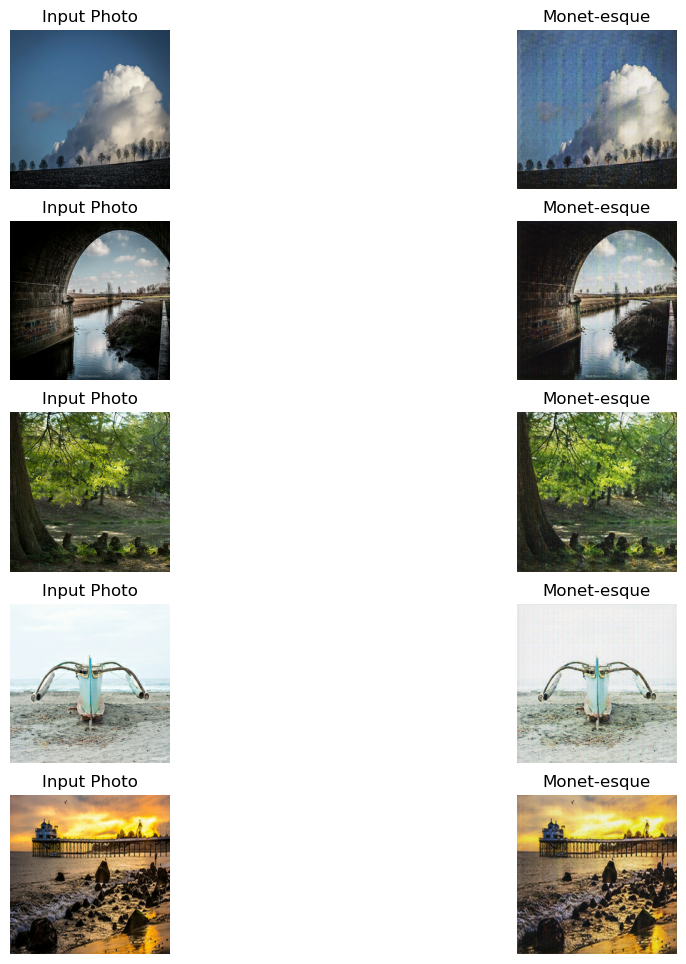

In [35]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet-esque")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Model Commentary

From the images above, it seems that the CycleGAN generated a better output than the previous model. The Monet-esque translation is much more clear in this model.

After trying various hyperparameters, the best learning rate was 2e-4. Increasing the initializer standard deviation to 0.05 improved the model and was able to generate the above output. Adding extra downsampling and upsampling blocks and using BatchNormalization() also helped in improving the output.

## Submission File

In [36]:
import PIL
! mkdir ../images

In [37]:
i = 1
for img in photo_dataset:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1

In [38]:
import shutil
import os

shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")
print(f"Number of generated samples: {len([name for name in os.listdir('../images/') if os.path.isfile(os.path.join('../images/', name))])}")

Number of generated samples: 7038


## Conclusion

In this project, I've learned how to implement a CycleGAN with the help of TensorFlow and Amy Jang's tutorial. GANs were a little difficult to understand and required hours of reading through Keras and Tensorflow tutorials as well as a few Kaggle notebooks. 

Training the CycleGAN took some time, even when running it on a GPU. While training the model for different hyperparameters, I found that changing the standard deviation of the initializers and using BatchNormalization can significantly impact the output. It was interesting to see how the output can change by reducing or increasing the number of downsampling and upsampling blocks used in the generator and discriminator. 

Since this project used modified UNET architecture, in future works, I would like to try to implement the RESNET architecture of CycleGAN to see if the images can be translated better. Kaggle mentioned that DCGAN can be used to create Monet-style art. I would like to try to implement DCGAN in the future as well.

## References

1. https://www.kaggle.com/code/amyjang/monet-cyclegan-tutorial/notebook
2. https://www.kaggle.com/code/jesperdramsch/understanding-and-improving-cyclegans-tutorial
3. https://www.kaggle.com/code/dimitreoliveira/improving-cyclegan-monet-paintings#notebook-container
4. https://github.com/victor369basu/CycleGAN-with-Self-Attention
5. https://keras.io/examples/generative/cyclegan/
6. https://www.tensorflow.org/tutorials/generative/pix2pix